#### Libraries

In [1]:
import os
import sys
import glob
import numpy as np
import  scipy.optimize    as op
import matplotlib.pyplot as plt
import urllib.request
from astropy.io import fits as pyfits
from astropy.table import Table
from astropy.io import fits
from collections import namedtuple, OrderedDict
from astropy import units as u
from astropy.coordinates import SkyCoord
from mw_plot import mw_radec # milkyway plane in RA/DEC
from matplotlib import gridspec
from matplotlib.patches import FancyArrowPatch

local_dir = "/home/holman/FILES/catalogs/"
plots_dir = "/home/holman/p1d_tools/PLOTS/"

#### Data entry

In [20]:
def cat_tabread(name):
    cat = fits.open(os.path.join(local_dir,name))
    data = Table.read(cat[1])
    L = len(data)
    z = np.array(data['Z']) # Redshift array the catalog
    z_max = max(z) # Maximum redshift of the catalog
    No_BALp = len(data[data['BI_CIV']<=0]) # No BAL quasars sorting
    BALp = len(data[data['BI_CIV']>0]) # Bal quasars sorting
    BALpie = np.array([No_BALp,BALp]) #Proportions for Pie Chart
    BALper = np.array([round((No_BALp/L)*100,2),round((BALp/L)*100,2)])#Percentages for Pie Chart

    RA = data['RA'] # Degree
    DEC = data['DEC'] # Degree
    
    cat.close()
    return L,z,round(z_max,2),BALpie,BALper,RA,DEC

In [24]:
cat_tabread('DR14Q_v4_4.fits')[4]

array([95.84,  4.16])

# General stats main catalogs

In [21]:
def stat_maincat(names,titles = ['eBOSS DR14Q','eBOSS DR16Q'],img_title='catalogs'):
    names = np.array(names)
    
    plt.rcParams["figure.autolayout"] = True
    plt.rcParams['axes.spines.left'] = False
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.bottom'] = False

    g_colors = ["#4C934C","#6F8695","#19381F",'#30362F'] # Main color 1, main color 2, reject color, edgecolor
    lbls = ["No BAL", "BAL"]
    expl = [0, 0.5]
    txt_prop = {'style' : 'oblique', 'family' : 'serif', 'size' :20}
    fig = plt.subplots(len(names), 2, gridspec_kw={'width_ratios': [2, 1]},figsize=(15.2,10.64),dpi=100)


    c = 1 # Counter for plot iteration
    for n in range(len(names)):
        data = cat_tabread(names[n])
        if (data[0]>=1000):
            N = str(data[0])
            N = N[0:3]+r'$\,$'+N[3:]
        else:
            N = str(data[0])
        if (n%2==0):
            mn = 0    # Main color selection
        else:
            mn = 1 # Main color selection
                
        plt.subplot(len(names), 2, c)
        plt.hist(data[1],alpha = 1, color =g_colors[mn], 
                 label = titles[n]+f": {N}", range = (0,7), bins = 35, edgecolor=g_colors[3])
        plt.xlabel("z", style = 'oblique', family = 'serif', size = 20)
        plt.ylabel("N", style = 'oblique', family = 'serif', size = 20)
        if (n==0):
            plt.title("Redshift distribution", weight='normal', style= 'normal', family = 'serif', size =20)
        plt.legend(loc="upper right", prop = txt_prop)
        plt.text(data[2]-2, data[0]*0.015, ('$z_{max} = $'+str(data[2])), \
        bbox = {'facecolor': 'white', 'alpha': 0.25, 'boxstyle': "round,pad=0.3", 'ec': 'green'}, size = 20)
        plt.yticks(fontsize = 15)
        plt.xticks(fontsize = 15)
        

        c = c+1
        
        plt.subplot(len(names), 2, c)
        plt.pie(data[3], labels = lbls, explode = expl, colors = [g_colors[mn],g_colors[2]], textprops = {'fontsize': 0},
               wedgeprops={"edgecolor":g_colors[3],'linewidth': 2, 'linestyle': '-', 'antialiased': True})
        if (n==0):
            plt.title("BAL proportion", weight='normal', style= 'normal', family = 'serif', size =20)
        plt.legend(loc="upper right", prop = txt_prop)
        plt.text(-0.9, 0.2,f"{data[4][0]}% ({data[3][0]})", \
                 bbox = {'facecolor': g_colors[3], 'alpha': 0.7, 'boxstyle': "round,pad=0.3", 'ec': 'green'}, fontsize = 20, color = 'w')
        plt.text(0.6, -0.4,f"{data[4][1]}% ({data[3][1]})", \
                 bbox = {'facecolor': g_colors[3], 'alpha': 0.7, 'boxstyle': "round,pad=0.3", 'ec': 'green'}, fontsize = 20, color = 'w')

        c = c+1
        
    plt.savefig(plots_dir + '/' + img_title +'.png', bbox_inches='tight')
    plt.show()

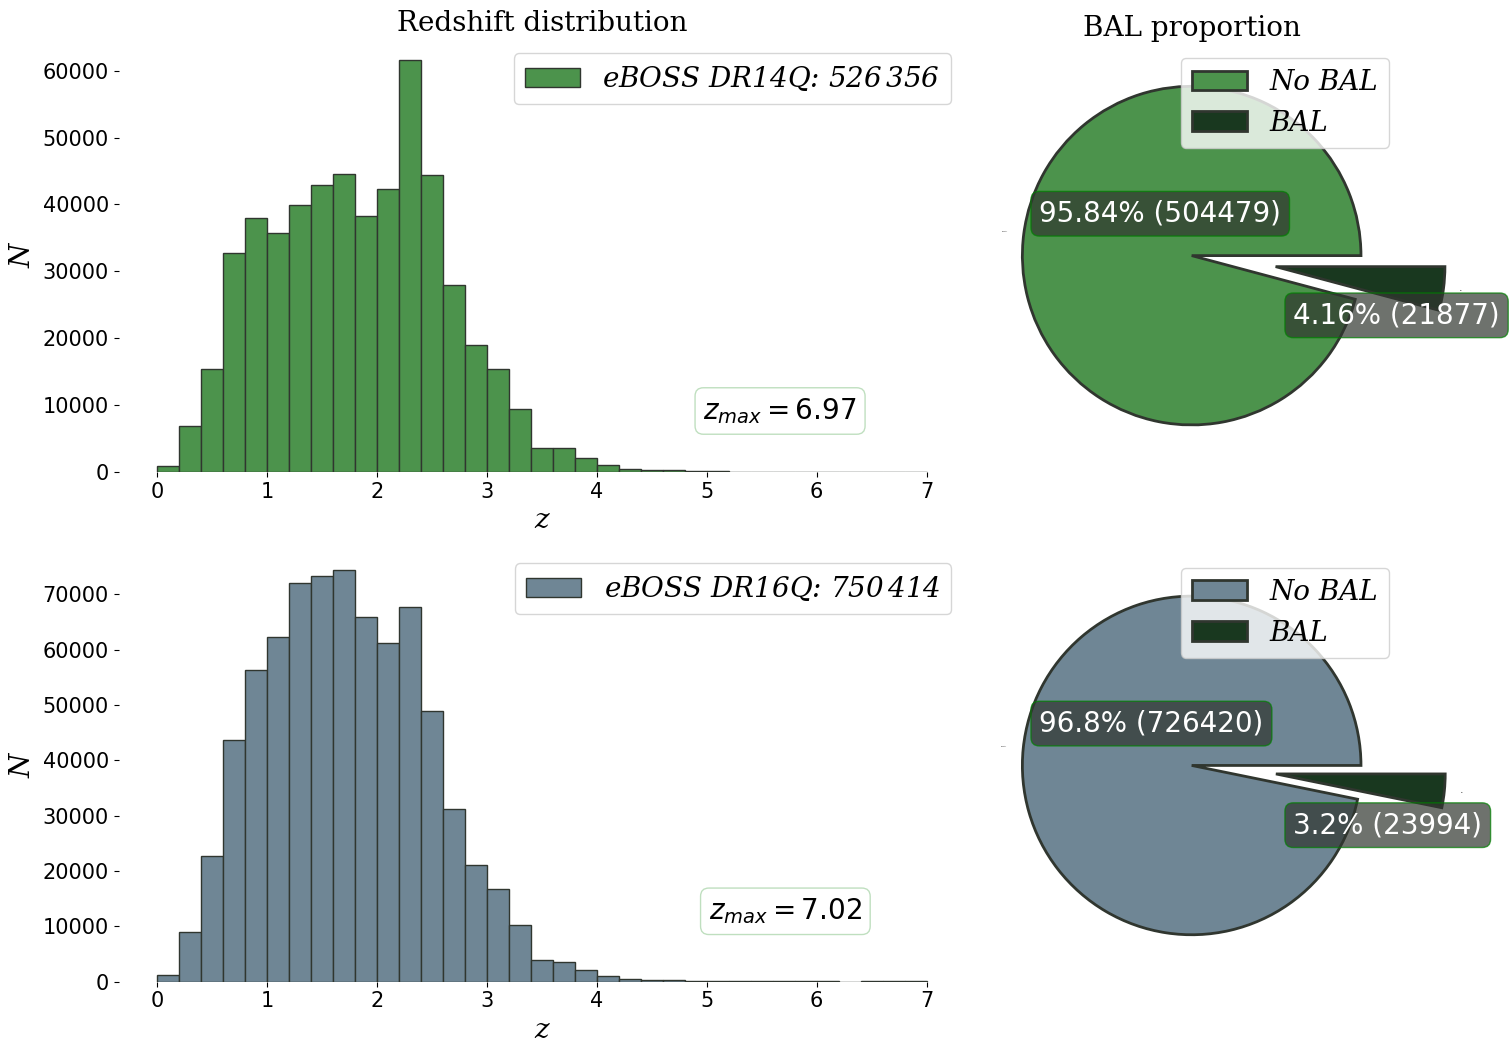

In [22]:
stat_maincat(['DR14Q_v4_4.fits','DR16Q_v4.fits'],img_title = 'eBOSS general cat')

# Sample on the sky

In [24]:
def hour(d):
    h = d*(24/360)
    return h

def rad(d):
    r = d*((2*np.pi)/360)
    return r

mw_ra, mw_dec = mw_radec(deg=True)

def to_plot(ra,dec):
    RA = np.array(ra)
    DEC = np.array(dec)
    eq = SkyCoord(RA, DEC, unit=u.deg)
    ra_rad = eq.ra.wrap_at(180 * u.deg).radian
    dec_rad = eq.dec.radian
    return np.array(ra_rad),np.array(dec_rad)

In [21]:
RA,DEC,z = [cat_tabread('BALsamDR16.fits')[5],cat_tabread('BALsamDR16.fits')[6],cat_tabread('BALsamDR16.fits')[1]]

In [22]:

def sky_sample(data,org=120,title=None, projection='mollweide',MW=True,mode='eBOSS DR14'):
    shift_ra = np.remainder(data[0]+360-org,360) # shift RA values
    ind = shift_ra>180
    shift_ra[ind] -=360    # scale conversion to [-180, 180]
    shift_ra=-shift_ra    # reverse the scale: East to the left
    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels+360+org,360)

    ax = plt.figure(layout="constrained",figsize=(15.2,9.5),dpi=100).subplot_mosaic(
        "AB",per_subplot_kw={
            "A": {"projection": projection},
            "B": {"projection": "polar"},
        },
        width_ratios = [1,0.5]
    )
    ax['A'].scatter(np.radians(shift_ra),np.radians(data[1]),label = f"DR16Q sample: {len(data[0])} QSO",
                    s=0.1, alpha=0.4, color = 'green')
    if (MW==True):
        mwx = np.remainder(mw_ra+360-org,360) # shift RA values
        ind2 = mwx>180
        mwx[ind2] -=360
        mwx=-mwx
        ax['A'].scatter(np.radians(mwx), np.radians(mw_dec),label = "MW plane",
                    s=1, alpha=0.7, color = 'black', marker = "_")
    
    ax['A'].set_xticklabels(tick_labels)
    #ax['A'].set_title('Sky projection map',x = 0.5,y = 1.1,
             #weight='normal', style = 'normal', family = 'serif', size =20)
    ax['A'].set_xlabel("RA[°]", size = 20, style = 'oblique', family = 'serif')
    ax['A'].set_ylabel("Dec[°]", size = 20, style = 'oblique', family = 'serif')
    ax['A'].grid(True,linestyle=':')
    txt_prop = {'style' : 'oblique', 'family' : 'serif', 'size' :17}
    ax['A'].legend(loc="lower right", markerscale=15,prop = txt_prop) #

    colors = data[2]
    ax['B'].scatter(np.radians(data[0]), data[2], c=colors, alpha=0.95,cmap='cubehelix', s=2)
    ax['B'].set_theta_zero_location('W', offset=90)
    #ax['B'].set_title("Sample in redshift space",weight='normal', style = 'normal', family = 'serif', size =20)
    #label_position1=ax['B'].get_rlabel_position()
    ax['B'].text((np.pi/2)+0.1,((max(data[2])-min(data[2]))/2)+2,r'z',
            rotation=0,ha='center',va='center', style = 'oblique', family = 'serif', size = 15)
    ax['B'].grid(True,linestyle=':')
    ax['B'].arrow(np.pi/2,min(data[2])+1,0,max(data[2])-3,
                  length_includes_head = True,head_width = 0.05, head_length = 0.3, color = 'black')
    style="Simple,tail_width=0.7,head_width=5,head_length=8"
    kw = dict(arrowstyle=style)
    a1 = FancyArrowPatch((np.radians(270), 6), (np.radians(315), 6),connectionstyle="arc3,rad=0.2", **kw)

    ax['B'].add_patch(a1)
    ax['B'].text(np.radians(292.5),5.0,r"RA[°]",
                 rotation=0,ha='center',va='center', style = 'oblique', family = 'serif', size =15)
    plt.savefig(plots_dir + f'/{mode}.png', bbox_inches='tight')
    plt.show()



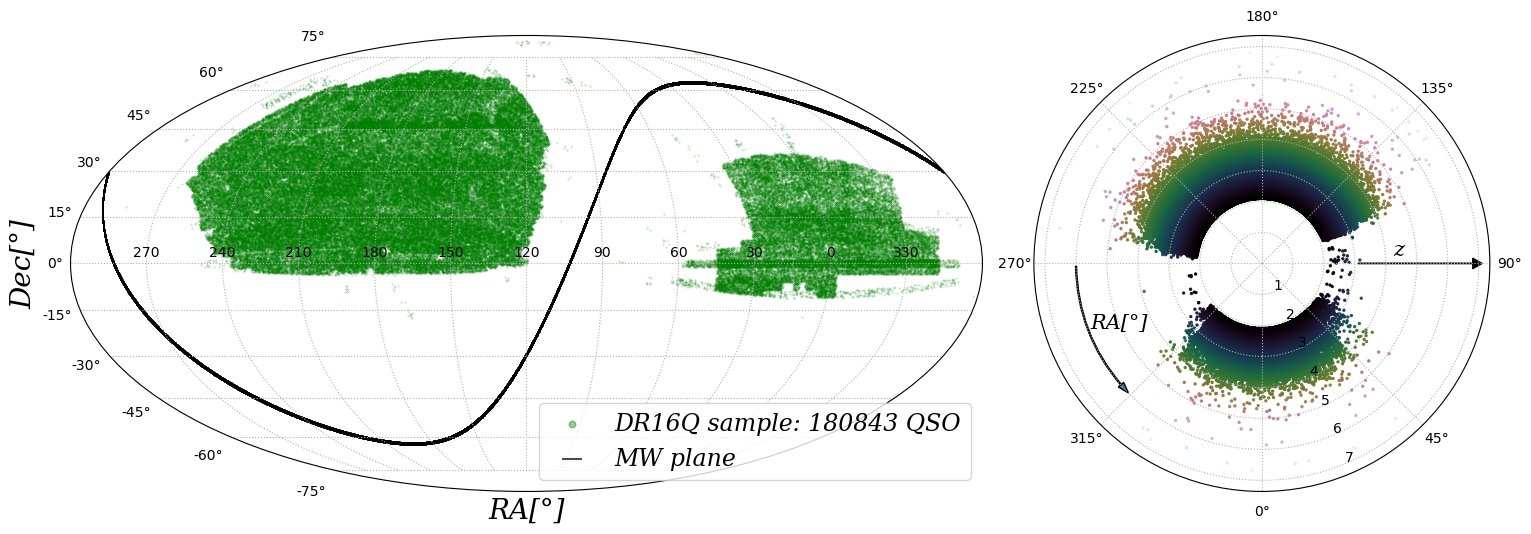

In [26]:
sky_sample([RA,DEC,z], mode = 'dr16sky')

#### BLA and DLA Proportion in the sample

In [51]:
fileDR14 = "BALsamDR14.fits"
fileDR16 = "BALsamDR16.fits"


local_fileDR14 = os.path.join(local_dir,fileDR14)
local_fileDR16 = os.path.join(local_dir,fileDR16)

dr14 = Table.read(local_fileDR14)
dr16 = Table.read(local_fileDR16)

In [52]:
a = (dr14['BI_CIV']<=0)
b = (dr14['BI_CIV']>0)

I14 = len(dr14[a])
Ib14 = len(dr14[b])
pidat14 = np.array([I14,Ib14])
nBAL14 = [(I14/len(dr14))*100,(Ib14/len(dr14))*100]

c = (dr16['BI_CIV']<=0)
d = (dr16['BI_CIV']>0)

I16 = len(dr16[c])
Ib16 = len(dr16[d])
pidat16 = np.array([I16,Ib16])
nBAL16 = [(I16/len(dr16))*100,(Ib16/len(dr16))*100]

In [55]:
fDLA_DR14 = "DLA_DR14CorRa.fits"
fDLA_DR16 = "DLA_DR16.fits"
l_fdlaDR14 = os.path.join(local_dir,fDLA_DR14)
l_fdlaDR16 = os.path.join(local_dir,fDLA_DR16)
DLA14 = Table.read(l_fdlaDR14)
DLA16 = Table.read(l_fdlaDR16)


MCID_14 = np.array(dr14['THING_ID']) 
MCID_16 = np.array(dr16['THING_ID'])

dlaID_14 = np.array(DLA14['THING_ID'])
dlaID_16 = np.array(DLA16['THING_ID'])

A = np.intersect1d(MCID_14,dlaID_14)
mask14 = np.isin(MCID_14,A)
mask14 = np.invert(mask14)
tp14 = MCID_14[mask14]

B = np.intersect1d(MCID_16,dlaID_16)
mask16 = np.isin(MCID_16,B)
mask16 = np.invert(mask16)
tp16 = MCID_16[mask16]


colrs14 = ["#4C934C", "#19381F"]
colrs16 = ["#6F8695", "#19381F"]
edgecol = '#F4F1BB'

expl = [0, 0.5]
z_ticks = [0,2,3,4,5,6,7]
N_ticks = [0,10000,20000,30000,40000,50000,60000]
txt_prop = {'style' : 'oblique', 'family' : 'serif', 'size' :25}

titles = ['DR14Q P1D sample','DR16Q P1D sample']


/tmp/ipykernel_30253/619947670.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax['z'].set_xticklabels(z_ticks,fontsize = 15)
/tmp/ipykernel_30253/619947670.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax['z'].set_yticklabels(N_ticks,fontsize = 15)


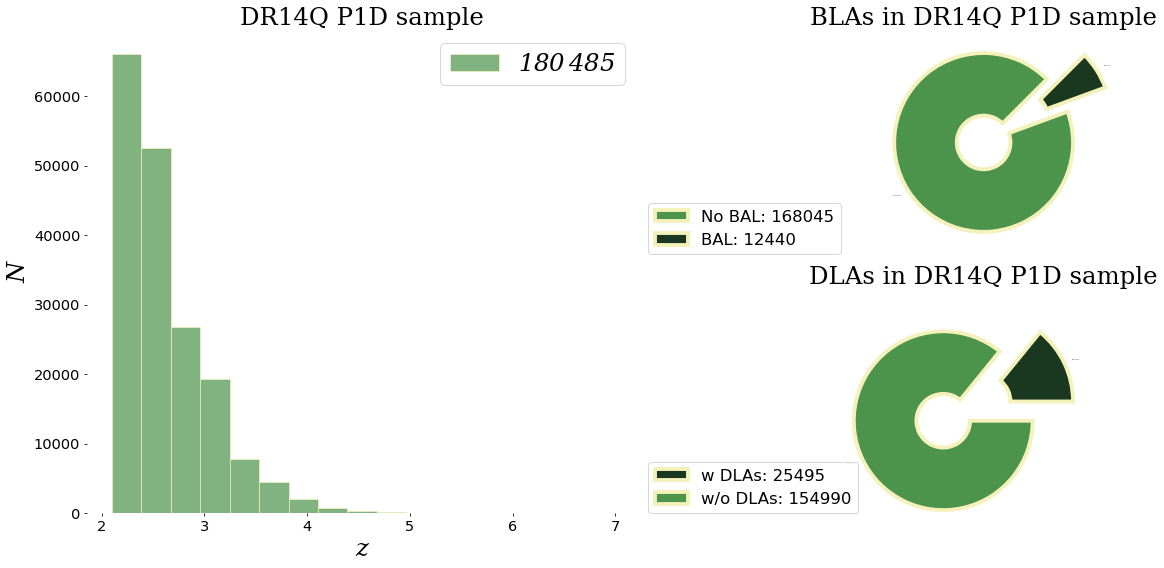

In [59]:
fig, ax = plt.subplot_mosaic([['z', 'BAL'], ['z', 'DLA']],layout='constrained',
                              figsize=(16,8), width_ratios = [1,0.5], height_ratios = [1,1], dpi = 70)


ax['z'].hist(dr14['Z'],alpha = 0.7, color =colrs14[0], label = str(len(dr14))[0:3]+'$\,$'+str(len(dr14))[3:6]
             ,bins = 17, edgecolor=edgecol)
ax['z'].set_xlabel("z",style = 'oblique', family = 'serif', size = 25)
ax['z'].set_ylabel("N",style = 'oblique', family = 'serif', size = 25)
ax['z'].set_title(titles[0]+"", weight='normal', style= 'normal', family = 'serif', size =25)
ax['z'].legend(loc="upper right", prop = txt_prop)
ax['z'].set_xticklabels(z_ticks,fontsize = 15)
ax['z'].set_yticklabels(N_ticks,fontsize = 15)
ax['z'].spines['top'].set_visible(False)
ax['z'].spines['right'].set_visible(False)
ax['z'].spines['left'].set_visible(False)
ax['z'].spines['bottom'].set_visible(False)

lbls = ["No BAL: "+str(I14), "BAL: "+str(Ib14)]
ax['BAL'].pie(pidat14,  startangle=45, 
        labels = lbls, explode = expl, colors =colrs14, textprops = {'fontsize': 0}, 
        wedgeprops={"edgecolor":edgecol,'linewidth': 4, 'linestyle': '-', 'antialiased': True, 'width' : 0.7})
ax['BAL'].set_title("BLAs in "+titles[0][0:9]+" sample",weight='normal', style= 'normal', family = 'serif', size =25)
ax['BAL'].legend(fontsize = 17, loc =[-1,0])



lbls = ["w DLAs: "+str(len(A)), "w/o DLAs: "+str(len(tp14))]
ax['DLA'].pie([len(A), len(tp14)], startangle=0, 
        labels = lbls, explode = expl, colors =np.flip(colrs14), textprops = {'fontsize': 0}, 
        wedgeprops={"edgecolor":edgecol,'linewidth': 4, 'linestyle': '-', 'antialiased': True, 'width' : 0.7})
ax['DLA'].set_title("DLAs in "+titles[0][0:9]+" sample",weight='normal', style= 'normal', family = 'serif', size =25)
ax['DLA'].legend(fontsize = 17, loc =[-1,0])
    
    
    

/tmp/ipykernel_30253/1150182939.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax['z'].set_xticklabels(z_ticks,fontsize = 15)
/tmp/ipykernel_30253/1150182939.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax['z'].set_yticklabels(N_ticks,fontsize = 15)


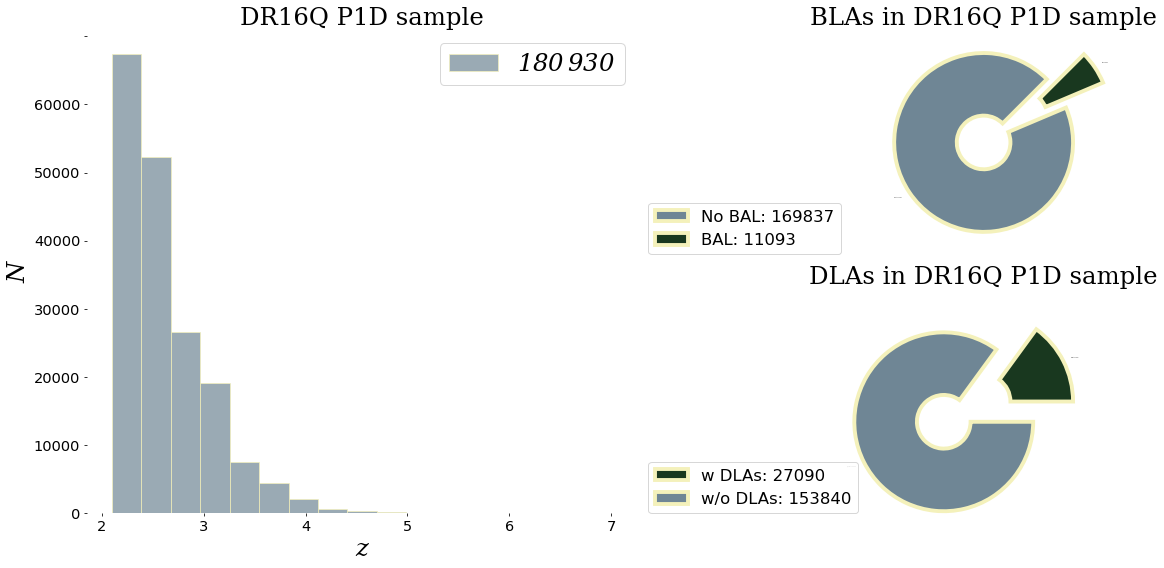

In [61]:
fig, ax = plt.subplot_mosaic([['z', 'BAL'], ['z', 'DLA']],layout='constrained',
                              figsize=(16,8), width_ratios = [1,0.5], height_ratios = [1,1], dpi = 70)


ax['z'].hist(dr16['Z'],alpha = 0.7, color =colrs16[0], label = str(len(dr16))[0:3]+'$\,$'+str(len(dr16))[3:6]
             ,bins = 17, edgecolor=edgecol)
ax['z'].set_xlabel("z",style = 'oblique', family = 'serif', size = 25)
ax['z'].set_ylabel("N",style = 'oblique', family = 'serif', size = 25)
ax['z'].set_title(titles[1]+"", weight='normal', style= 'normal', family = 'serif', size =25)
ax['z'].legend(loc="upper right", prop = txt_prop)
ax['z'].set_xticklabels(z_ticks,fontsize = 15)
ax['z'].set_yticklabels(N_ticks,fontsize = 15)
ax['z'].spines['top'].set_visible(False)
ax['z'].spines['right'].set_visible(False)
ax['z'].spines['left'].set_visible(False)
ax['z'].spines['bottom'].set_visible(False)

lbls = ["No BAL: "+str(I16), "BAL: "+str(Ib16)]
ax['BAL'].pie(pidat16,  startangle=45, 
        labels = lbls, explode = expl, colors =colrs16, textprops = {'fontsize': 0}, 
        wedgeprops={"edgecolor":edgecol,'linewidth': 4, 'linestyle': '-', 'antialiased': True, 'width' : 0.7})
ax['BAL'].set_title("BLAs in "+titles[1][0:9]+" sample",weight='normal', style= 'normal', family = 'serif', size =25)
ax['BAL'].legend(fontsize = 17, loc =[-1,0])


lbls = ["w DLAs: "+str(len(B)), "w/o DLAs: "+str(len(tp16))]
ax['DLA'].pie([len(B), len(tp16)], startangle=0, 
        labels = lbls, explode = expl, colors =np.flip(colrs16), textprops = {'fontsize': 0}, 
        wedgeprops={"edgecolor":edgecol,'linewidth': 4, 'linestyle': '-', 'antialiased': True, 'width' : 0.7})
ax['DLA'].set_title("DLAs in "+titles[1][0:9]+" sample",weight='normal', style= 'normal', family = 'serif', size =25)
ax['DLA'].legend(fontsize = 17, loc =[-1,0])
    

#### Redshift space

In [62]:
def hour(d):
    h = d*(24/360)
    return h

def rad(d):
    r = d*((2*np.pi)/360)
    return r

#### Coordinates

In [63]:

import numpy as np
import matplotlib.pyplot as plt

titles = ['DR14Q subcatalog','DR16Q subcatalog']

RA14 = np.array(dr14['RA'])
DEC14 = np.array(dr14['DEC'])
eq14 = SkyCoord(RA14, DEC14, unit=u.deg)

ra_rad14 = eq14.ra.wrap_at(180 * u.deg).radian
dec_rad14 = eq14.dec.radian
z14 = np.array(dr14['Z'])
z16 = np.array(dr16['Z'])

RA16 = np.array(dr16['RA'])
DEC16 = np.array(dr16['DEC'])
eq16 = SkyCoord(RA16, DEC16, unit=u.deg)

ra_rad16 = eq16.ra.wrap_at(180 * u.deg).radian
dec_rad16 = eq16.dec.radian

/tmp/ipykernel_30253/1878295739.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot(121, projection='aitoff')
/tmp/ipykernel_30253/1878295739.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(122, projection='polar')


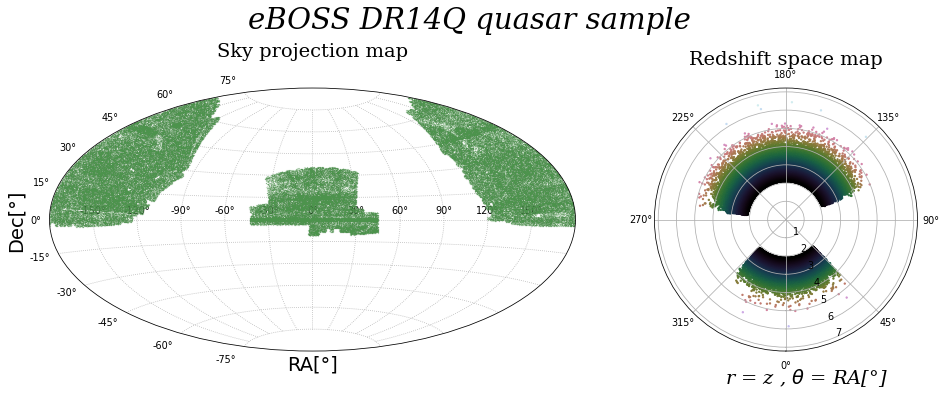

/tmp/ipykernel_30253/2996675860.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot(121, projection='aitoff')
/tmp/ipykernel_30253/2996675860.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(122, projection='polar')


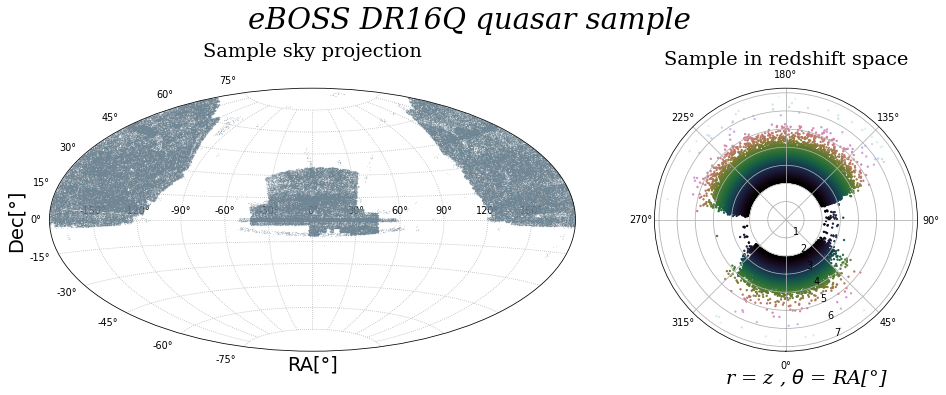

In [72]:
fig, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]},figsize=(16,10),dpi=70)

ax0 = plt.subplot(121, projection='aitoff')
ax0.set_title('Sample sky projection',x = 0.5,y = 1.1,
              weight='normal', style = 'normal', family = 'serif', size =20)
ax0.set_xlabel("RA[°]", size = 20)
ax0.set_ylabel("Dec[°]", size = 20)
ax0.plot(ra_rad16, dec_rad16, '*', markersize=0.7, alpha=0.2, color = colrs16[0])
ax0.grid(True,linestyle=':')

ax1 = plt.subplot(122, projection='polar')
colorsDR16 = dr16['Z']
ax1.scatter(rad(dr16['RA']), dr16['Z'], c=colorsDR16, alpha=0.95,cmap='cubehelix', s=2)
ax1.set_theta_zero_location('W', offset=90)
ax1.set_title("Sample in redshift space",weight='normal', style = 'normal', family = 'serif', size =20)
label_position1=ax1.get_rlabel_position()
ax1.text(np.radians(label_position1-15),ax1.get_rmax()+1.5,r'r = z , ${\theta}$ = RA[°]',
        rotation=0,ha='center',va='center', style = 'oblique', family = 'serif', size = 20)

fig.suptitle('eBOSS DR16Q quasar sample',x = 0.5,y = 0.8,weight='normal',
             style = 'oblique',family = 'serif',fontsize = 30)

plt.show()